In [1]:
import requests
from tqdm import tqdm
import time

카카오 API
키워드로 장소 검색: https://developers.kakao.com/docs/latest/ko/local/dev-guide#search-by-keyword

카카오 개발자 API 키 발급: https://developers.kakao.com/
App 생성 REST API 키 복사, 붙여넣기

In [ ]:
import requests
import json

app_key = '{your_key}'

url = 'https://dapi.kakao.com/v2/local/search/keyword.json'
params = {
    'query': '약국',
    'category_group_code': 'PM9',
    'page': 45
}
headers = {
    'Authorization': app_key
}

# 응답 객체 먼저 저장
res = requests.get(url=url, params=params, headers=headers)

# 여기서만 status_code 확인해야 함
if res.status_code == 200:
    tokens = res.json()  # 여기서부터 dict 됨

    with open('db.json', 'w', encoding='utf-8') as f:
        json.dump(tokens, f, ensure_ascii=False, indent=2)

    print("✅ 저장 완료: db.json")
else:
    print(f"❌ 요청 실패: {res.status_code}")
    print(res.text)


✅ 저장 완료: db.json


In [53]:
tokens['documents']

[{'address_name': '서울 강북구 수유동 95-7',
  'category_group_code': 'PM9',
  'category_group_name': '약국',
  'category_name': '의료,건강 > 약국',
  'distance': '',
  'id': '9871683',
  'phone': '02-988-2552',
  'place_name': '세화온누리약국',
  'place_url': 'http://place.map.kakao.com/9871683',
  'road_address_name': '서울 강북구 도봉로77길 6',
  'x': '127.022975621251',
  'y': '37.6337585009902'},
 {'address_name': '서울 종로구 종로4가 185',
  'category_group_code': 'PM9',
  'category_group_name': '약국',
  'category_name': '의료,건강 > 약국',
  'distance': '',
  'id': '9885727',
  'phone': '02-2264-8210',
  'place_name': '열린약국',
  'place_url': 'http://place.map.kakao.com/9885727',
  'road_address_name': '서울 종로구 종로 204',
  'x': '127.000285254981',
  'y': '37.5706914035499'},
 {'address_name': '인천 남동구 만수동 898-7',
  'category_group_code': 'PM9',
  'category_group_name': '약국',
  'category_name': '의료,건강 > 약국',
  'distance': '',
  'id': '13526595',
  'phone': '032-471-8248',
  'place_name': '고은약국',
  'place_url': 'http://place.map.ka

In [54]:
tokens['meta']

{'is_end': True,
 'pageable_count': 45,
 'same_name': {'keyword': '약국', 'region': [], 'selected_region': ''},
 'total_count': 20189}

In [44]:
# 한계 45페이지까지 값 밖에 받아올 수 없음
params = {
    'query': '치킨',
    'page': 46
}

res = requests.get(url, params=params, headers=headers).json()

print(res)

{'errorType': 'ValidationError', 'message': 'Request validation is failed', 'details': [{'field': 'query.page', 'error': 'should be at most 45'}]}


In [55]:
# TinyDB
#!pip install tinydb
from tinydb import TinyDB, Query

db = TinyDB('db.json')

분할 검색
우리나라 지도를 위경도 0.25 단위의 작은 사각형으로 쪼개어 검색

상세페이지에서 가격 긁어오기 https://place.map.kakao.com/main/v/9847579

IP 차단 피하기 위해 5초 대기

DB 저장
place_name: 음식점 이름
menu: 메뉴 이름
price: 가격

In [ ]:
# 실행 x
start_x = 126 # 126.0 - 130.0
start_y = 33 # 33.0 - 39.0

dx = 0.25
dy = 0.25

for i in tqdm(range(18)):
    for j in range(26):
        x = start_x + dx * i
        y = start_y + dy * j
        print(x, y)

        for page in range(1, 46):
            params = {
                'query': '약국',
                'page': page,
                'rect': f'{x},{y},{x + dx},{y + dy}'
            }

            res = requests.get(url, params=params, headers=headers).json()

            if len(res['documents']) == 0:
                break

            for doc in res['documents']:
                place_name = doc['place_name']

                detail_url = f'https://place.map.kakao.com/main/v/{doc["id"]}'

                data = requests.get(detail_url, headers=headers).json()

                if 'menuInfo' not in data:
                    continue

                menu_list = data['menuInfo']['menuList']

                for menu_item in menu_list:
                    price = 0
                    if 'price' in menu_item:
                        price = int(menu_item['price'].replace(',', ''))

                    db.insert({
                        'place_name': place_name,
                        'menu': menu_item['menu'],
                        'price': price
                    })

                time.sleep(5)

            if res['meta']['is_end']:
                break

In [ ]:
db

<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=56202, all_tables_documents_count=['_default=56202']>

In [ ]:
# 35,000원 초과하는 메뉴 검색
db.search(Query().price > 35000)

[{'place_name': '돌담너머바다 판포점', 'menu': '돔베 스테이크', 'price': 39000},
 {'place_name': '마담나탈리소셜클럽', 'menu': '글렌피딕 15Y', 'price': 250000},
 {'place_name': '인판포', 'menu': '바베큐 플레이터', 'price': 60000},
 {'place_name': '인판포', 'menu': '마라소라새우', 'price': 40000},
 {'place_name': '제마닭', 'menu': '닭도리탕(대)', 'price': 36000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(중)', 'price': 38000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(대)', 'price': 48000},
 {'place_name': '먹고정', 'menu': '백돼지한근반', 'price': 63000},
 {'place_name': '먹고정', 'menu': '백돼지한근', 'price': 42000},
 {'place_name': '먹고정', 'menu': '흑돼지한근반', 'price': 80000},
 {'place_name': '먹고정', 'menu': '흑돼지한근', 'price': 54000},
 {'place_name': '모루쿠다', 'menu': '모루쿠다 육합', 'price': 40000},
 {'place_name': '원조장수통닭', 'menu': '토종닭', 'price': 60000},
 {'place_name': '원조장수통닭', 'menu': '오리주물럭', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '토종닭(1마리)', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '오리(1마리)', 'price': 60000},
 {'place_name': '오름지미정원', 'menu': '찹스테이크 (3

In [ ]:
# 35,000 초과 AND "치" 포함
db.search((Query().price > 35000) & (Query().menu.search('치')))

[{'place_name': '화덕에꾸운닭 전남담양점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '아웃닭 신촌역점', 'menu': '오리지날 레드핀 양념치킨', 'price': 187000},
 {'place_name': '누구나홀딱반한닭 홍대점', 'menu': '바사칸치빵파티', 'price': 36900},
 {'place_name': '크치치킨 경희대점', 'menu': '치킨세트D', 'price': 37000},
 {'place_name': '누구나홀딱반한닭 선릉점', 'menu': '바사칸치빵파티', 'price': 38900},
 {'place_name': '화덕에꾸운닭 강원홍천점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '화덕에꾸운닭 창원진동점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '앗싸마늘닭 본점', 'menu': '앗싸 스페셜 두마리 치찜세트', 'price': 37900}]

In [ ]:
# 전국 치킨 평균 가격(프랜차이즈를 모두 포함하여 정확한 가격은 아님)
chickens = db.search(Query().menu.search('치'))

prices = []

for chicken in chickens:
    prices.append(chicken['price'])

avg_price = sum(prices) / len(prices)

print('치킨 %d개의 평균 가격은 %.2f원 입니다' % (len(chickens), avg_price))

치킨 22670개의 평균 가격은 17762.21원 입니다


<Axes: ylabel='Count'>

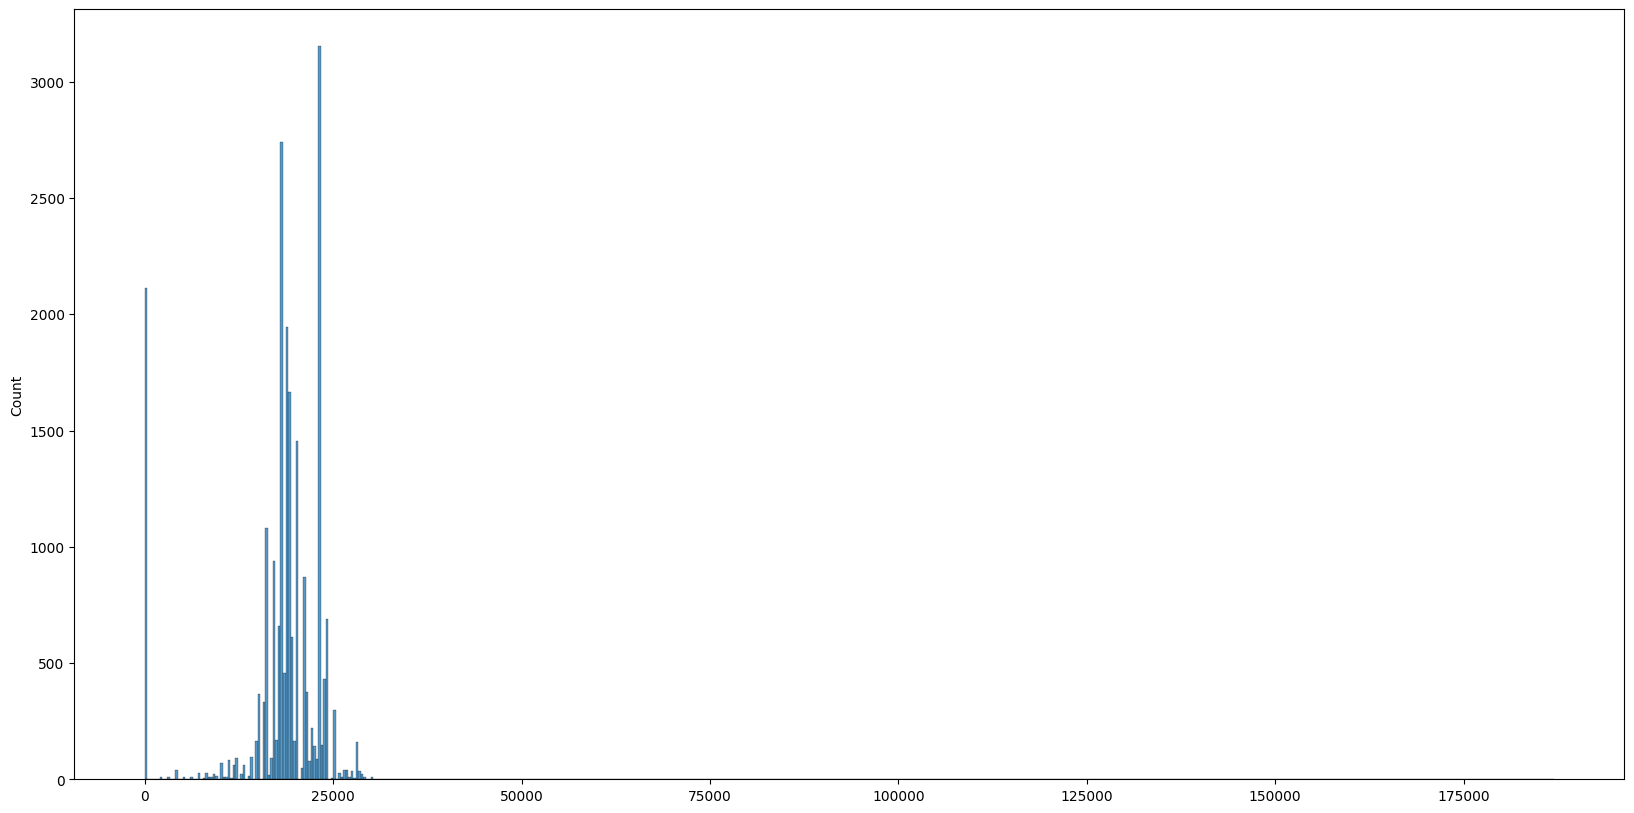

In [ ]:
# 가격 분포 그래프
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x=prices, ax=ax)

# 약국 찾기 - DB연결

In [57]:
import requests

def get_pharmacy_data(query, page, api_key):
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}
    params = {
        "query": query,
        "category_group_code": "PM9",  # 약국
        "page": page
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()['documents']
    else:
        print("❌ 요청 실패:", response.status_code)
        return []


In [ ]:
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:{YOUR_HOST}/")
print(client.list_database_names())


['admin', 'config', 'local', 'medicine_kakao']


In [ ]:
from pymongo import MongoClient
from datetime import datetime

# MongoDB 연결
client = MongoClient("mongodb://localhost:{YOUR_HOST}/")
db = client['medicine_kakao']
collection = db["pharmacy_data"]

# 중복 방지를 위해 place_id 기준으로 upsert 설정
def save_to_mongo(docs):
    for doc in docs:
        record = {
            "place_id": doc["id"],
            "place_name": doc["place_name"],
            "category_name": doc.get("category_name", ""),
            "phone": doc.get("phone", ""),
            "address_name": doc.get("address_name", ""),
            "road_address_name": doc.get("road_address_name", ""),
            "x": float(doc["x"]),
            "y": float(doc["y"]),
            "place_url": doc.get("place_url", ""),
            "collected_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        # upsert: 기존 place_id가 있으면 업데이트, 없으면 삽입
        collection.update_one(
            {"place_id": record["place_id"]},
            {"$set": record},
            upsert=True
        )


In [ ]:
kakao_api_key = "{YOUR_KEY}"  # 개인 키

for page in range(1, 46):  # Kakao API 최대 45 page
    docs = get_pharmacy_data("약국", page, kakao_api_key)
    if not docs:
        break
    save_to_mongo(docs)
    print(f"✅ Page {page} 저장 완료")

print("🎉 모든 데이터 저장 완료")
